In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    FormFactorFile,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan, load_energy_scans,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import fit_differential_evolution, FitContext, FitTransform, TVRegularizer

In [4]:
o_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/O.ff")
sr_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Sr.ff")
ti_ff = FormFactorFile(path="/Users/niaggar25/Downloads/Experimental RXR data/Ti.ff")
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)

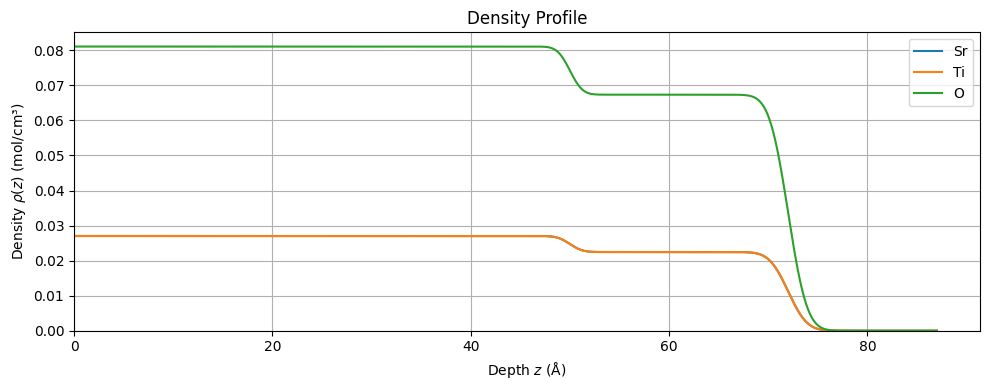

In [5]:
parameters_container = ParametersContainer()
crystal = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=4.96,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=2.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)

n_films = 4
init_thickness = 22.0
dthickness = init_thickness / n_films
density = 4.12
films = []
for i in range(n_films):
    film = create_compound(
        parameters_container=parameters_container,
        name=f"SrTiO3-film-{i}",
        formula="Sr:1,Ti:1,O:3",
        thickness=dthickness,
        density=density,
        atoms=[sr_atom, ti_atom, o_atom],
        roughness=0.0 if i < n_films - 1 else 3.0,
        prev_roughness=0.0,
        linked_prev_roughness=True,
    )
    films.append(film)

struc = Structure(name="SrTiO3-struc", n_compounds=n_films+1, params_container=parameters_container)
struc.add_compound(0, crystal)
for i, film in enumerate(films):
    struc.add_compound(i + 1, film)
struc.validate_compounds()

crystal.density.fit = True
for detail in crystal.compound_details:
    detail.roughness.independent = True
    detail.roughness.fit = True
    detail.roughness.upper = 15.0
    detail.roughness.lower = 0.0

def params_for_films(film):
    for detail in film.compound_details:
        detail.roughness.independent = True
        detail.roughness.fit = True
        detail.roughness.upper = 5.0
        detail.roughness.lower = 0.0

        detail.molar_density.independent = True
        detail.molar_density.fit = True
        detail.molar_density.upper = 0.1
        detail.molar_density.lower = 0

        detail.thickness.independent = True
        detail.thickness.fit = True
        detail.thickness.upper = 7.0
        detail.thickness.lower = 0.1

        detail.prev_roughness.independent = False
        detail.prev_roughness.fit = False
        detail.prev_roughness.upper = 10.0
        detail.prev_roughness.lower = 0.0


for film in films:
    params_for_films(film)

struc.create_layers(step=0.1)

def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")


# print(f"Number of layers: {struc.n_layers}")
# print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

In [6]:
experimental_rscans = load_reflectivity_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_AScans.dat',
    initial_name='B074_AScans',
)
experimental_escans = load_energy_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_EScans.dat',
    initial_name='B074_EScans',
)

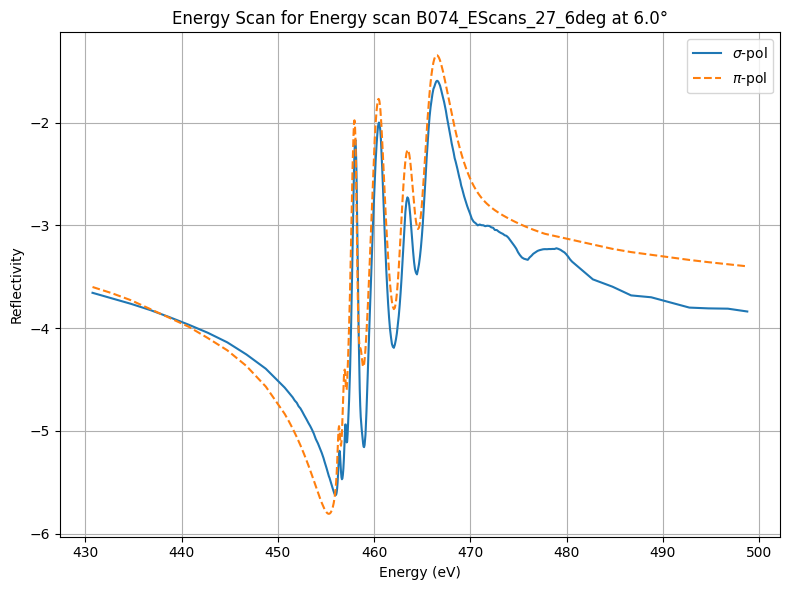

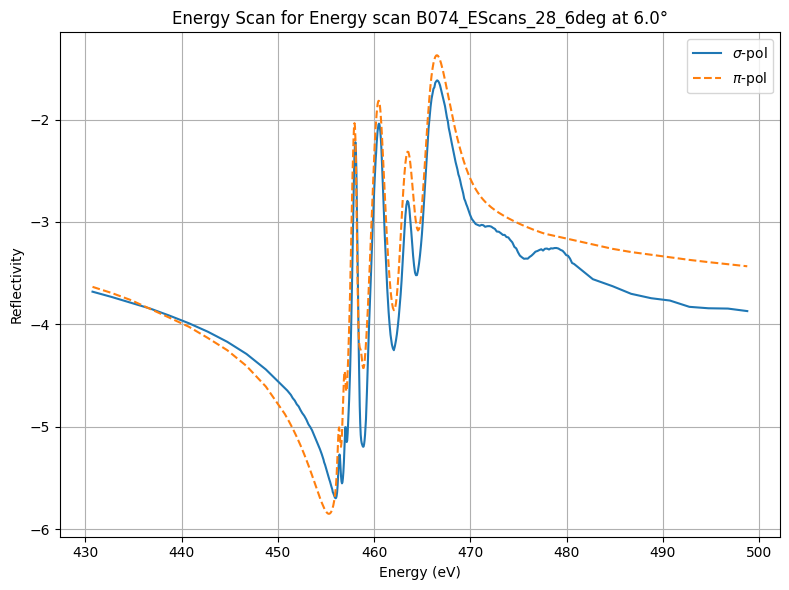

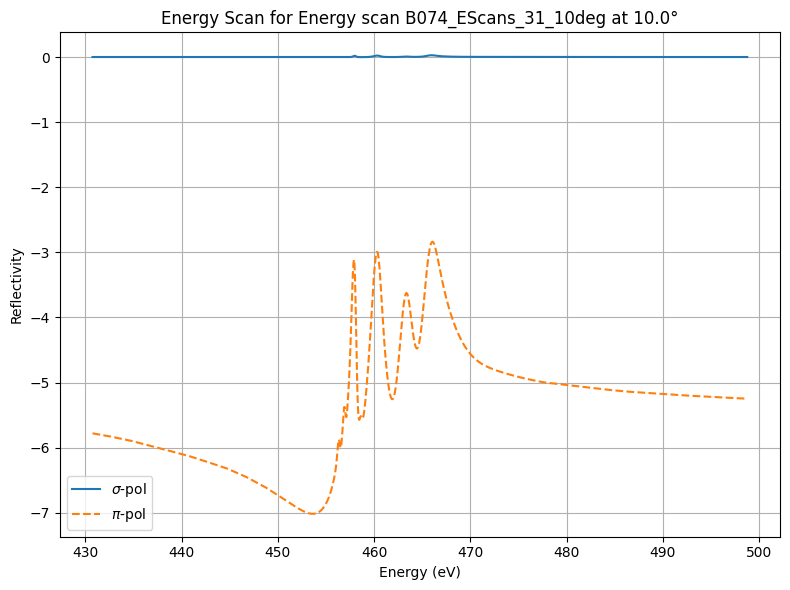

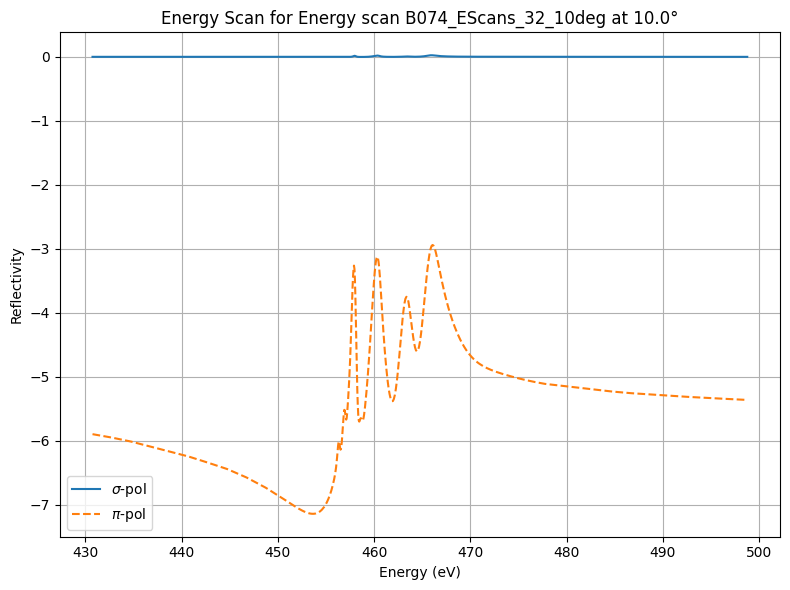

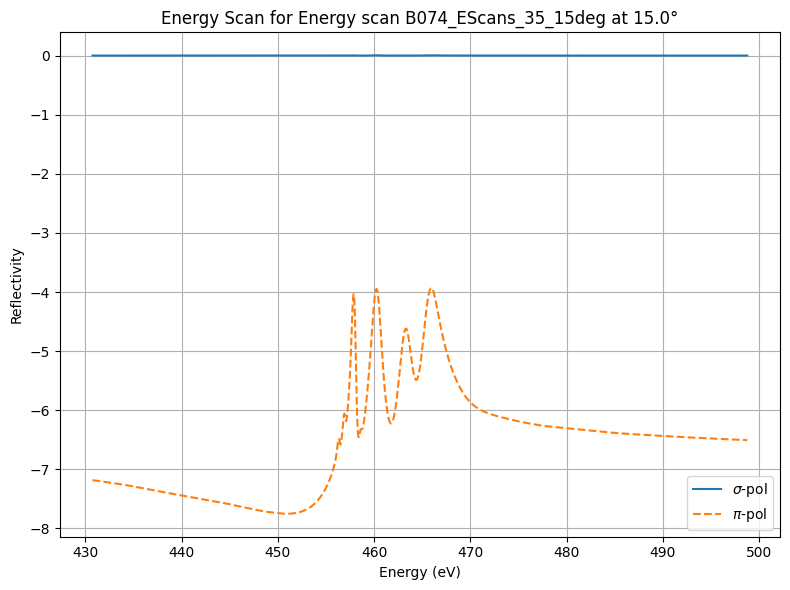

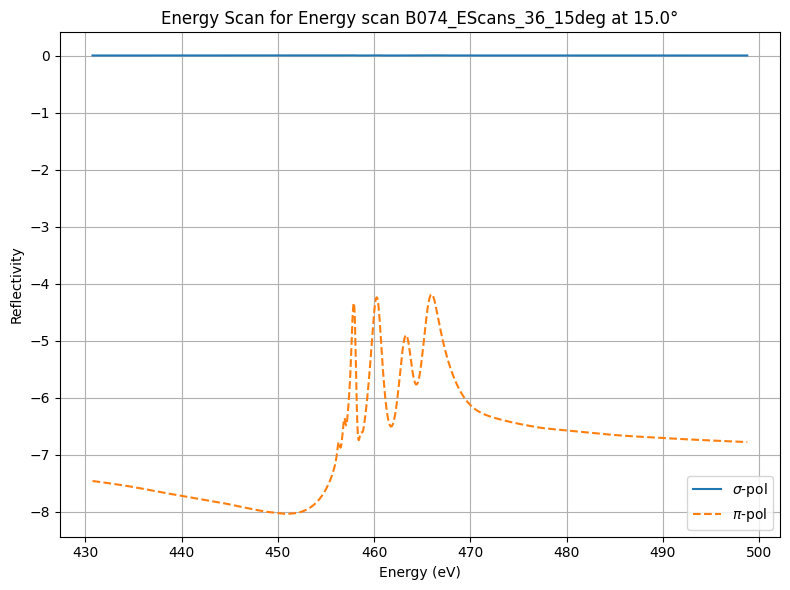

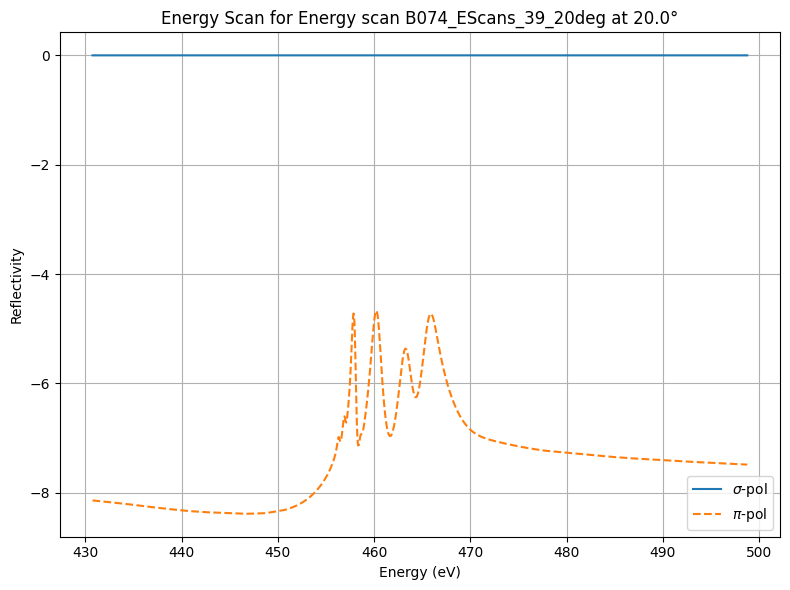

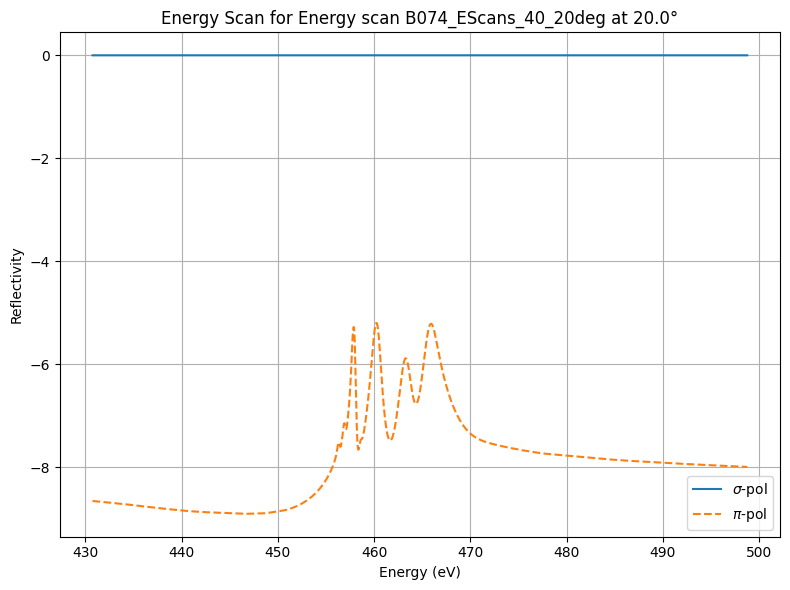

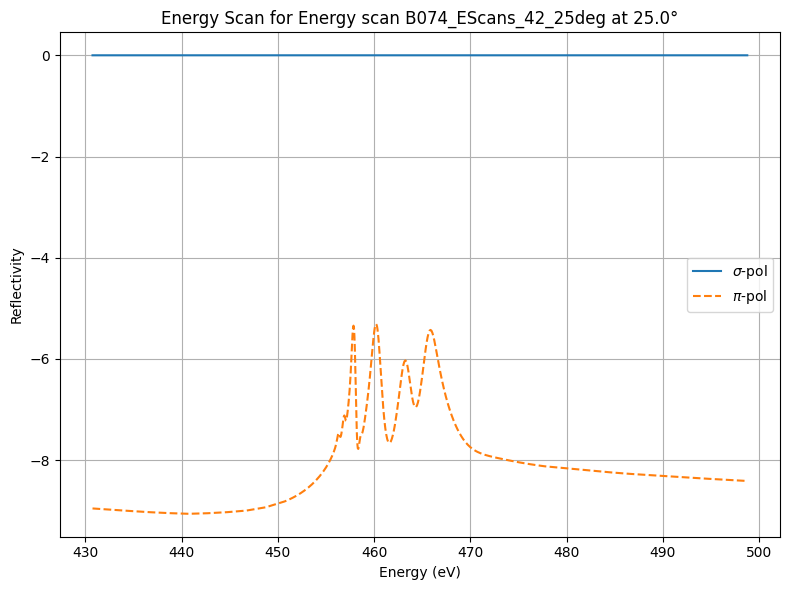

In [12]:
backend = PRReflectivityBackend(als=True)
for escan in experimental_escans:
    rsim = backend.compute_energy_scan(structure=struc, energy_range=escan.E_eV, theta=escan.theta_deg)
    r = rsim.R_s if escan.pol == "s" else rsim.R_p

    plot_energy_scan(escan.E_eV, escan.R, np.log(r), escan.theta_deg, f"Energy scan {escan.name}")

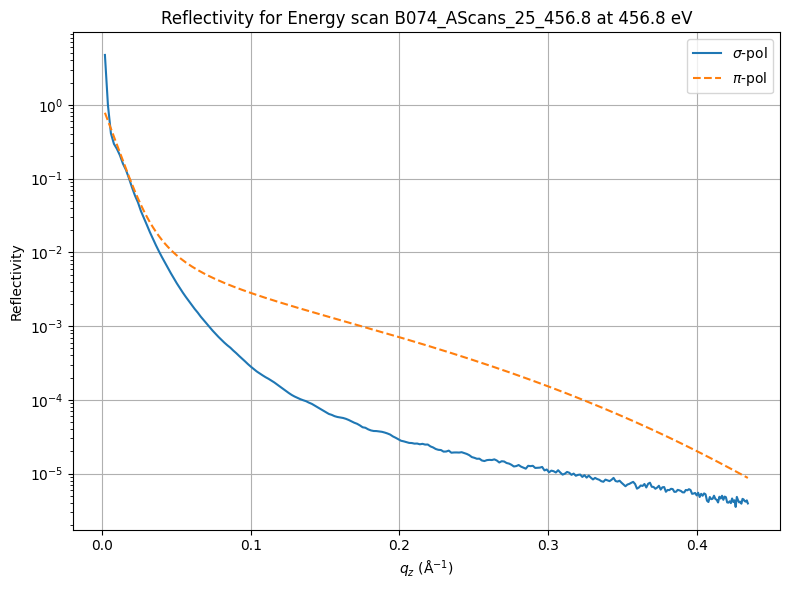

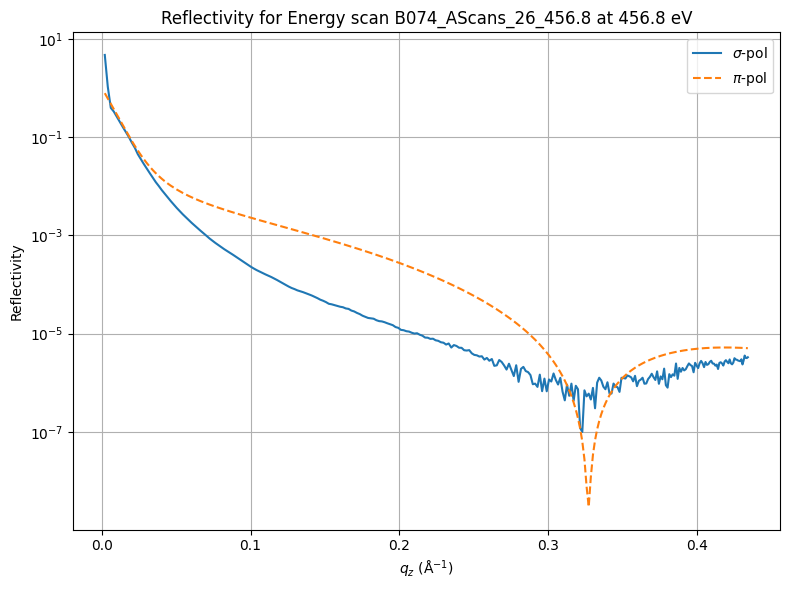

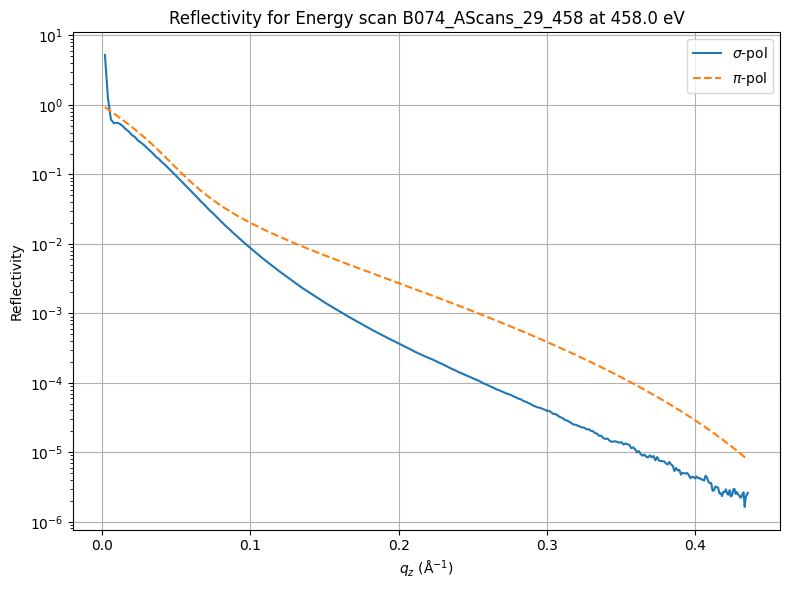

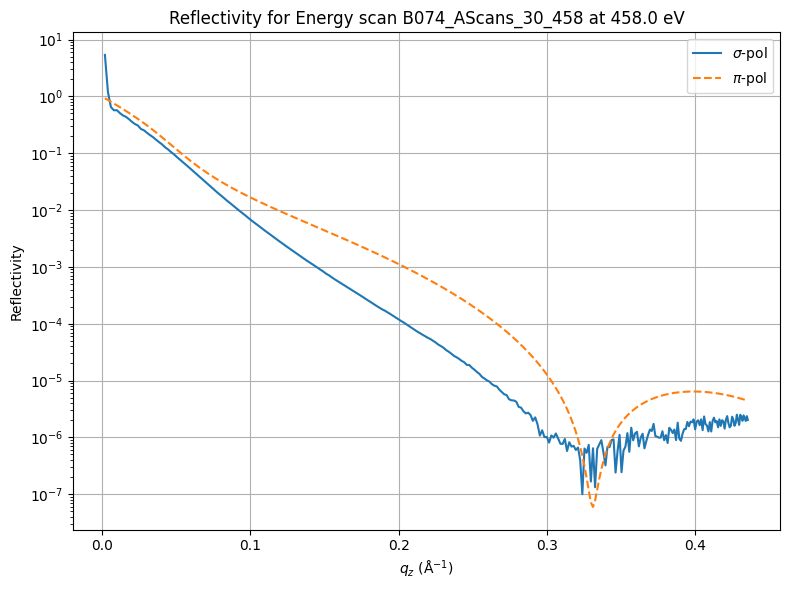

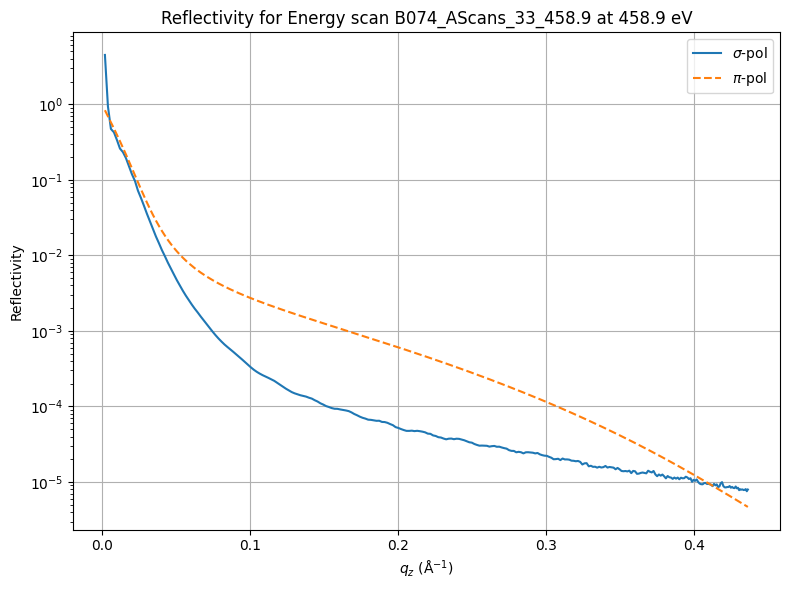

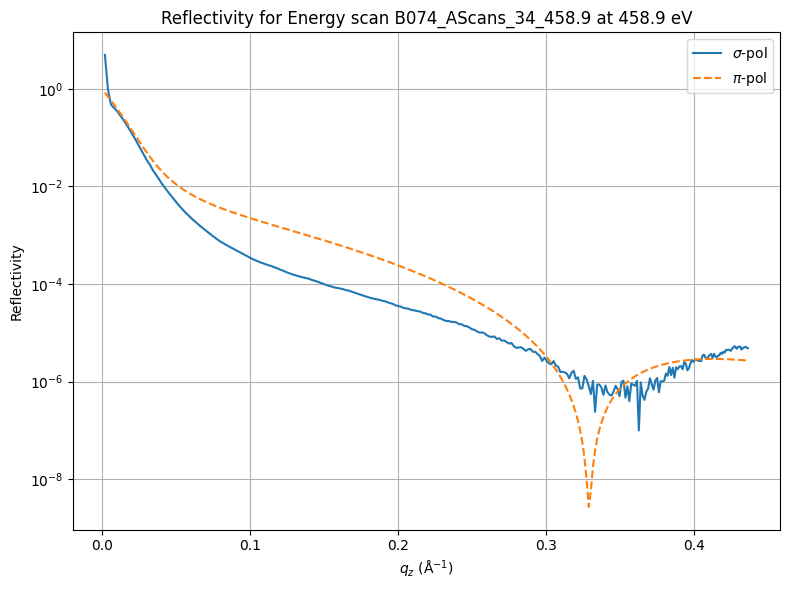

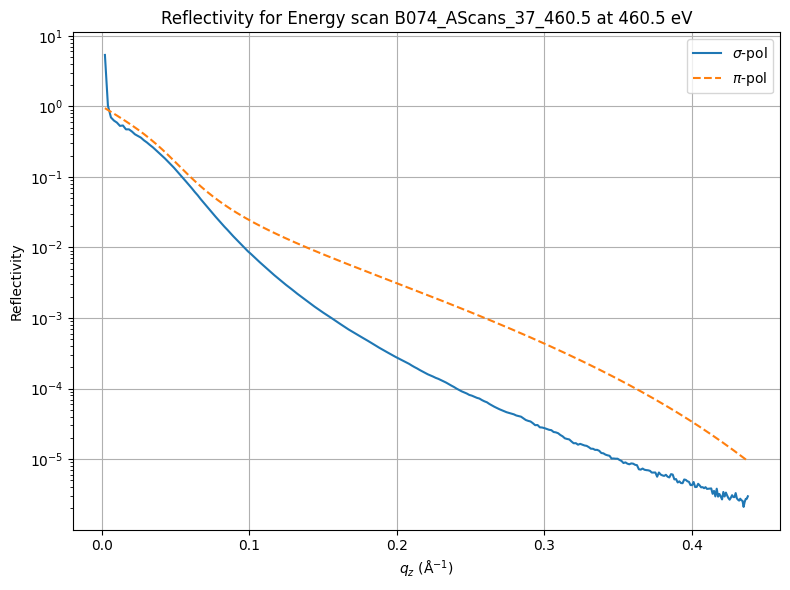

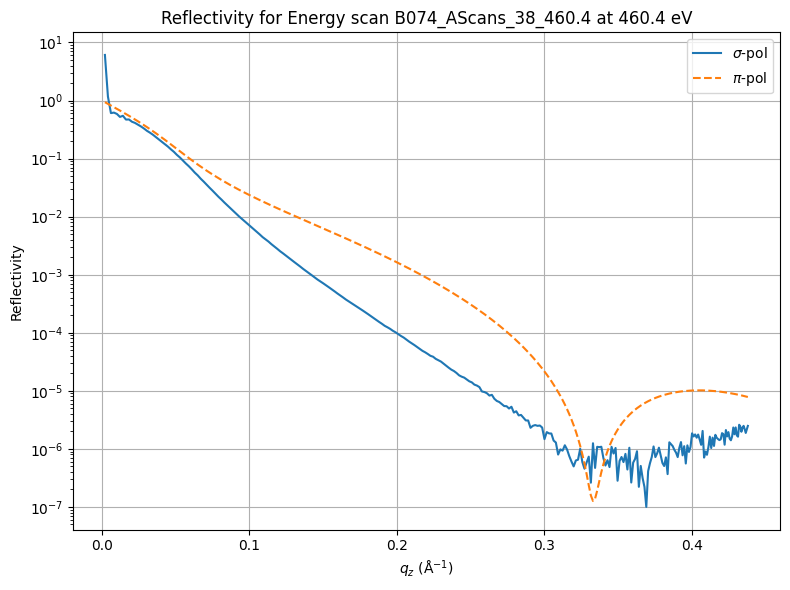

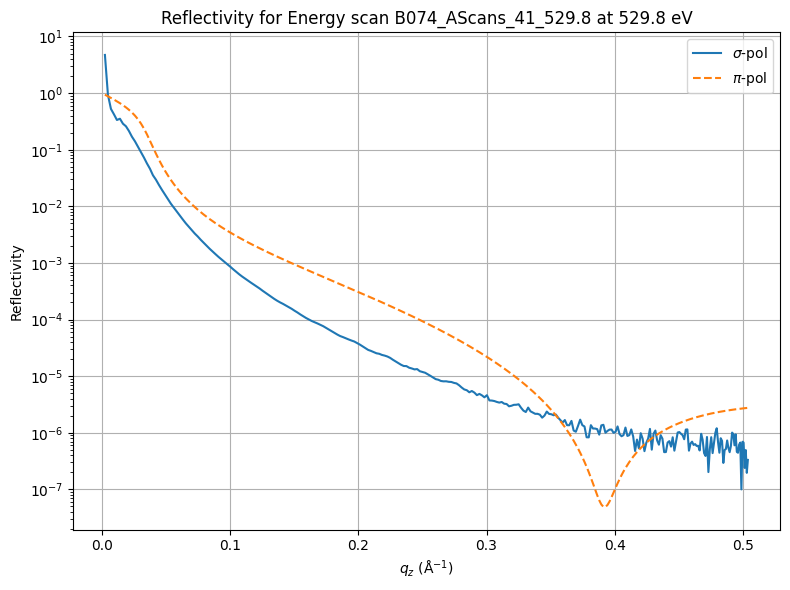

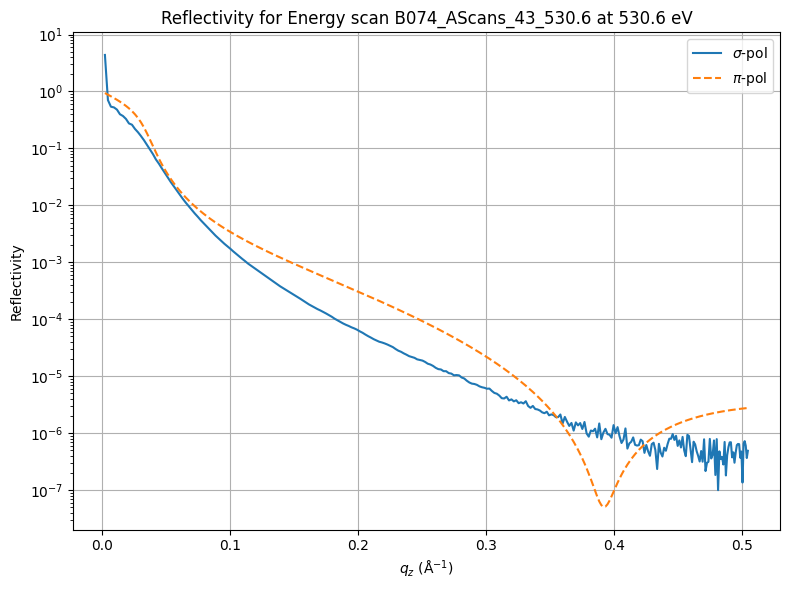

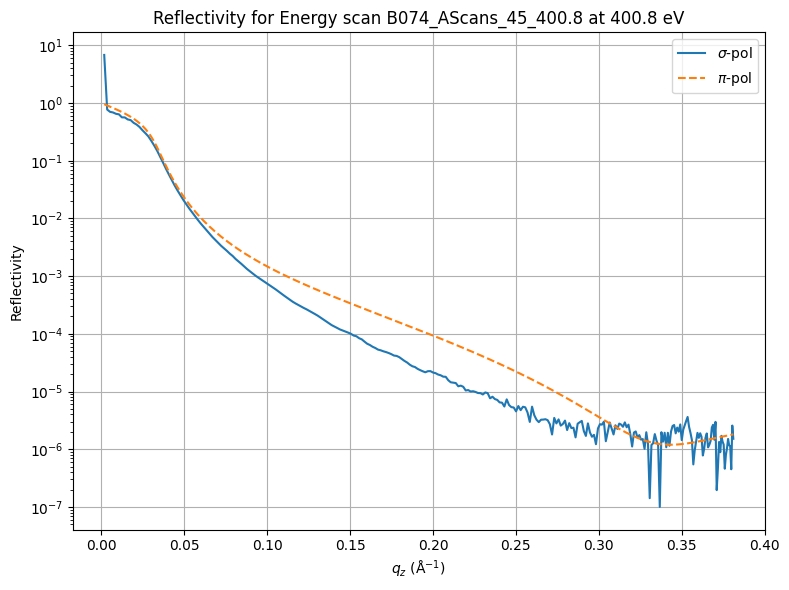

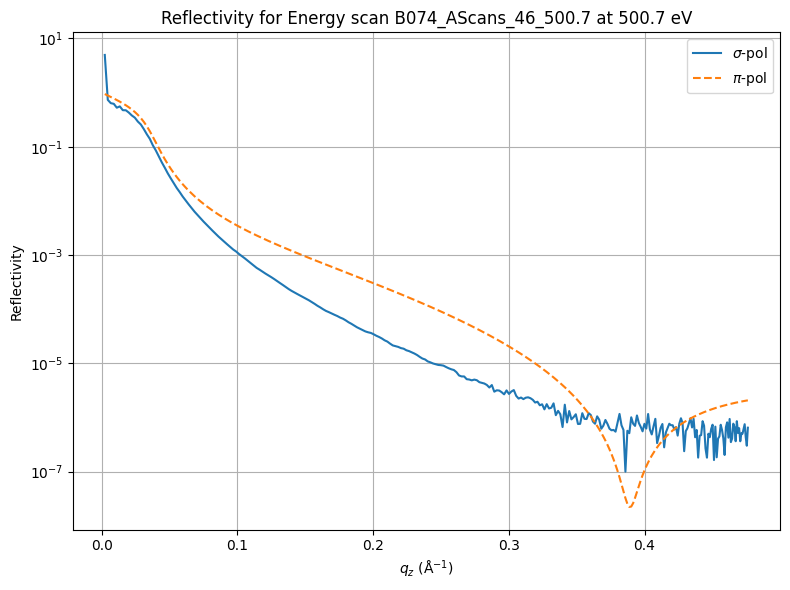

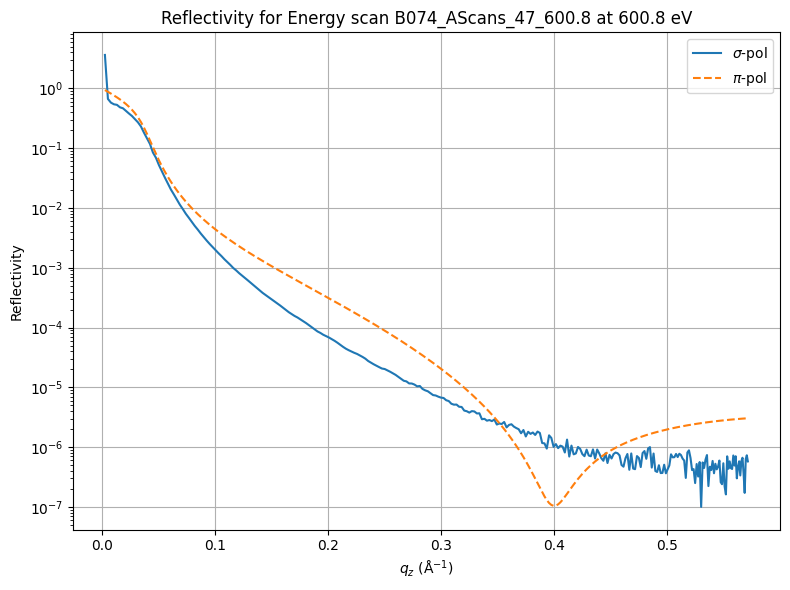

In [10]:
backend = PRReflectivityBackend(als=True)
for rscan in experimental_rscans:
    rsim = backend.compute_reflectivity(structure=struc, qz=rscan.qz, energy=rscan.energy_eV)
    r = rsim.R_s if rscan.pol == "s" else rsim.R_p

    plot_reflectivity(rscan.qz, rscan.R, r, rscan.energy_eV, f"Energy scan {rscan.name}")

2
Total cost: 158675.093736
Total cost: 3015835.829706
Total cost: 858089433.433028
Total cost: 6575444.851465
Total cost: 830429.091893
Total cost: 85676606.022447
Total cost: 7992977.174954
Total cost: 8949946.399169
Total cost: 8935948.437431
Total cost: 1010781.641499
Total cost: 17656842.828423
Total cost: 5819461.459132
Total cost: 138150.231714
Total cost: 13720812.651215
Total cost: 7072735.792535
Total cost: 3991326.738479
Total cost: 6064618.778730
Total cost: 60859987.027812
Total cost: 1423479.909578
Total cost: 9215378.676046
Total cost: 4892413.729303
Total cost: 7516176.919811
Total cost: 16578502.472445
Total cost: 386013.582120
Total cost: 6320165.701989
Total cost: 33262671.024184
Total cost: 2681200.250153
Total cost: 10765426.010663
Total cost: 6439756.842111
Total cost: 7385829.343748
Total cost: 29769668.556528
Total cost: 535284.484827
Total cost: 2560268.681208
Total cost: 13302653.320251
Total cost: 6540759.247404
Total cost: 372527957.130106
Total cost: 425723

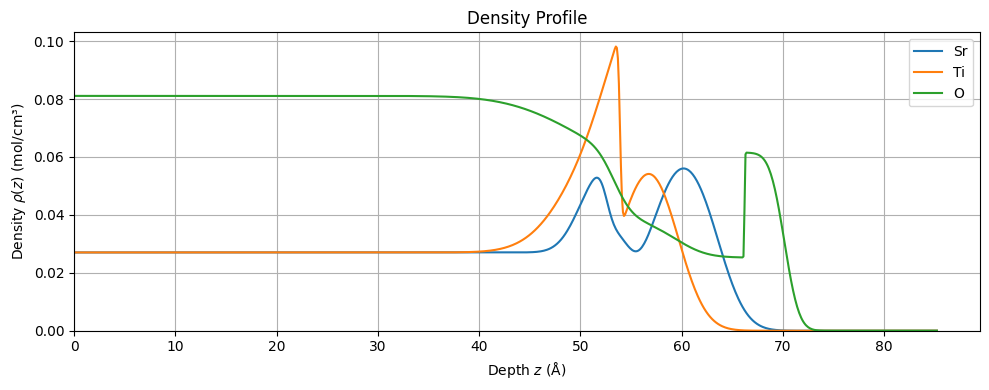

In [9]:
backend = PRParallelReflectivityBackend(als=True)
scale_param = parameters_container.new_parameter("scale", value=1.0, fit=True)
scale_param.upper = 1.0
scale_param.lower = 0.0
offset_param = parameters_container.new_parameter("offset", value=0.0, fit=True)
offset_param.upper = 2.0
offset_param.lower = 0

context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln", sim_scale=scale_param, sim_offset=offset_param),
    tv=TVRegularizer(),
    objective="chi2",
)
parameters = [
    param for param in parameters_container.parameters if param.fit
]

print(len(experimental_escans[0:2]))

res = fit_differential_evolution(
    x0=np.array(parameters_container.get_fit_vector()),
    params=parameters,
    ctx=context,
    ref_scans=[],
    # ref_scans=experimental_rscans,
    # en_scans=[],
    en_scans=experimental_escans[0:2],
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)